In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [3]:
price = pd.read_csv('PNJ.csv')
price['Close'] = price['Close'].astype('float64')
returns = 100*price['Close'].pct_change().dropna()

Text(0.5, 1.0, 'Returns')

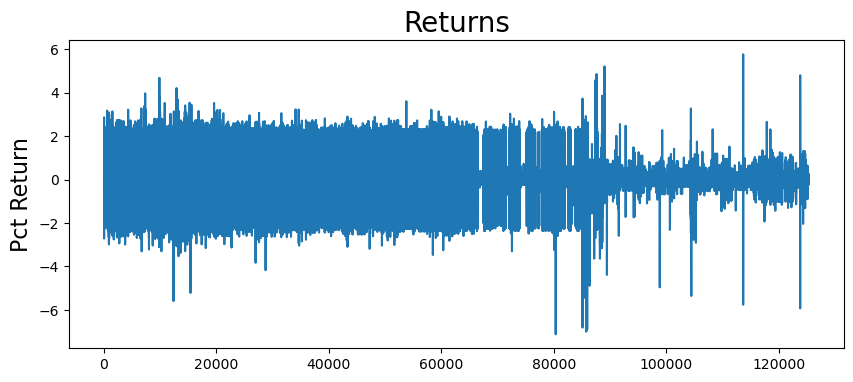

In [4]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('Returns', fontsize=20)

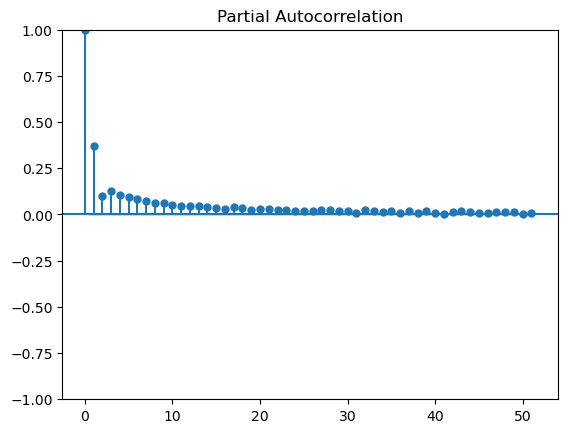

In [5]:
plot_pacf(returns**2)
plt.show()

In [6]:
#Fit GARCH

# Khởi tạo và ước lượng mô hình GARCH(1,1)
# Không thực hiện rescale, vô hiệu hóa cảnh báo
model = arch_model(returns, vol='Garch', p=1, q=1, mean='Zero', dist='normal', rescale=False)  # mean='Zero' cho mô hình chỉ xét volatility
model_fit = model.fit()


Iteration:      1,   Func. Count:      4,   Neg. LLF: 109316.39791675961
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109316.39881574635
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


In [7]:
# Hiển thị kết quả
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -109316.
Distribution:                  Normal   AIC:                           218639.
Method:            Maximum Likelihood   BIC:                           218668.
                                        No. Observations:               125308
Date:                Sun, Nov 17 2024   Df Residuals:                   125308
Time:                        16:12:40   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0161  1.492e-03     10.765  5.029e-27 [1.314e-02,1.899e-02]
alpha[1]       0.2000  7.200e-03     27.778 7.993e-170     [  0.186,  0.214]
beta[1]        0.7800  9.458e-03     82.471      0.000     [  0.761,  0.799]
============================================================================

Covariance estimator: robust
"""

In [8]:

print("Returns info:")
print(returns.describe())  # Thống kê cơ bản
print("Số lượng phần tử:", len(returns))  # Độ dài
print("Số giá trị NaN:", returns.isnull().sum())  # Kiểm tra giá trị NaN


Returns info:
count    125308.000000
mean          0.004008
std           0.896142
min          -7.117438
25%          -0.100258
50%           0.000000
75%           0.099658
max           5.758427
Name: Close, dtype: float64
Số lượng phần tử: 125308
Số giá trị NaN: 0


In [9]:

returns.index = pd.date_range(start='2018-02-28 09:15:00', periods=len(returns),freq='T')
rolling_predictions = []
test_size = 400 #400 for faster test on stocks
for i in range(test_size):
    # Tạo tập huấn luyện
    train = returns[:-(test_size - i)]
    # Định nghĩa và huấn luyện mô hình GARCH(1,0) vì (1,1) báo không phù hợp
    model = arch_model(train, p=1, q=0, mean='Zero', dist='normal', rescale=False)
    model_fit = model.fit(disp='off')
    # Dự báo 1 bước
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1, :][0]))  # Lấy căn bậc 2 phương sai dự báo
# Chuyển danh sách
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-400:])


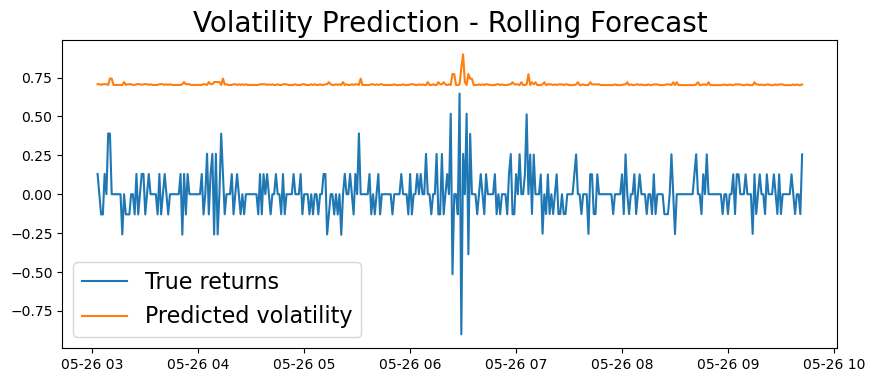

In [9]:
plt.figure(figsize=(10,4))
plt.plot(returns[-400:], label='True returns')
plt.plot(rolling_predictions, label='Predicted volatility')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(fontsize = 16)

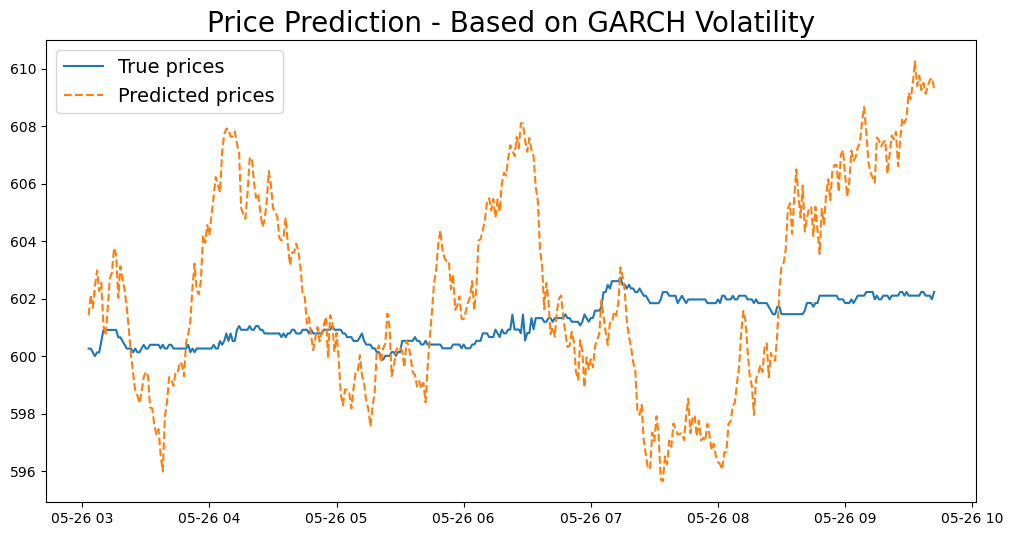

In [12]:
# Dataset: Giả sử 'prices' là chuỗi giá cổ phiếu với index là thời gian
prices = returns.cumsum() + 100  # Tạo chuỗi giá giả lập từ returns để minh họa
returns.index = prices.index

# Thêm bước dự báo biến động giá dựa trên GARCH dự báo
rolling_predictions_price = []
current_price = prices.iloc[-test_size - 1]  # Giá bắt đầu từ trước chuỗi dự báo

for i in range(test_size):
    volatility = rolling_predictions.iloc[i]  # Dự báo volatility từ GARCH
    # Mô phỏng biến động giá từ phân phối chuẩn
    price_change = np.random.normal(0, volatility)
    current_price += price_change
    rolling_predictions_price.append(current_price)

# Chuyển sang Series
rolling_predictions_price = pd.Series(rolling_predictions_price, index=prices.index[-test_size:])

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(prices[-test_size:], label='True prices')
plt.plot(rolling_predictions_price, label='Predicted prices', linestyle='--')
plt.title('Price Prediction - Based on GARCH Volatility', fontsize=20)
plt.legend(fontsize=14)
plt.show()

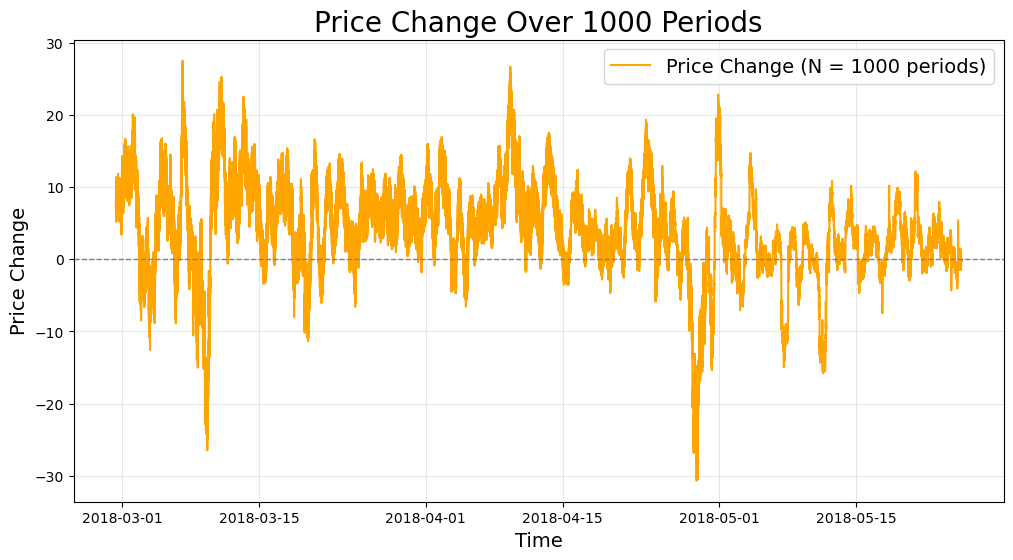

In [13]:

# Thời gian N (khoảng cách dự báo)
N = 1000  # Số phút sau

# Tính biến động giá (Delta P)
delta_price = prices.shift(-N) - prices

# Loại bỏ giá trị NaN do shift
delta_price = delta_price.dropna()

# Biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(delta_price, label=f'Price Change (N = {1000} periods)', color='orange')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Đường ngang tại y=0
plt.title(f'Price Change Over {N} Periods', fontsize=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price Change', fontsize=14)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.show()